In [1]:
!pip install biopython

   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.7 MB ? eta -:--:--
   ------- -------------------------------- 0.5/2.7 MB 910.5 kB/s eta 0:00:03
   ----------- ---------------------------- 0.8/2.7 MB 1.2 MB/s eta 0:00:02
   --------------- ------------------------ 1.0/2.7 MB 1.4 MB/s eta 0:00:02
   ----------------------- ---------------- 1.6/2.7 MB 1.6 MB/s eta 0:00:01
   ------------------------------ --------- 2.1/2.7 MB 1.7 MB/s eta 0:00:01
   ---------------------------------- ----- 2.4/2.7 MB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 2.7/2.7 MB 1.8 MB/s eta 0:00:00


In [4]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu


Looking in indexes: https://download.pytorch.org/whl/cpu
   ---------------------------------------- 0.0/109.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/109.2 MB ? eta -:--:--
   ---------------------------------------- 0.3/109.2 MB ? eta -:--:--
   ---------------------------------------- 0.5/109.2 MB 1.1 MB/s eta 0:01:43
   ---------------------------------------- 0.8/109.2 MB 1.0 MB/s eta 0:01:47
   ---------------------------------------- 0.8/109.2 MB 1.0 MB/s eta 0:01:47
   ---------------------------------------- 1.0/109.2 MB 864.1 kB/s eta 0:02:06
   ---------------------------------------- 1.0/109.2 MB 864.1 kB/s eta 0:02:06
   ---------------------------------------- 1.3/109.2 MB 827.8 kB/s eta 0:02:11
    --------------------------------------- 1.6/109.2 MB 850.2 kB/s eta 0:02:07
    --------------------------------------- 1.6/109.2 MB 850.2 kB/s eta 0:02:07
    --------------------------------------- 2.1/109.2 MB 893.8 kB/s eta 0:02:00
    ------------

In [1]:
import torch
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())


Torch version: 2.9.0+cpu
CUDA available: False


In [2]:
import zipfile
import os

# path to zip file
zip_path = "cafa-6-protein-function-prediction.zip"

# folder to extract to
extract_dir = "data"

# make sure the folder exists
os.makedirs(extract_dir, exist_ok=True)

# extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Extracted all files to: {extract_dir}")


Extracted all files to: data


In [3]:
from Bio import SeqIO
import pandas as pd

# Load sequences
train_sequences = list(SeqIO.parse("data/Train/train_sequences.fasta", "fasta"))
print(f"Total sequences: {len(train_sequences)}")

# Convert to DataFrame
seq_df = pd.DataFrame({
    "entry_id": [record.id for record in train_sequences],
    "sequence": [str(record.seq) for record in train_sequences],
})
seq_df["seq_len"] = seq_df["sequence"].str.len()
seq_df["entry_id"] = seq_df["entry_id"].str.extract(r"sp\|([^|]+)\|")[0]
#seq_df.head()

# Load taxonomy and GO terms
tax_df = pd.read_csv("data/Train/train_taxonomy.tsv", sep="\t",header=None)
tax_df.columns = ["entry_id", "taxonomy"]
terms_df = pd.read_csv("data/Train/train_terms.tsv", sep="\t")
terms_df.columns = terms_df.columns.str.lower()
terms_df.rename(columns={"entryid": "entry_id"}, inplace=True)

# Merge all
train_df =  (
    seq_df
    .merge(tax_df, on="entry_id", how="left")
    .merge(terms_df, on="entry_id", how="left")
)
train_df.head()


Total sequences: 82404


,entry_id,sequence,seq_len,taxonomy,term,aspect
0,A0A0C5B5G6,MRWQEMGYIFYPRKLR,16,9606,GO:0001649,P
1,A0A0C5B5G6,MRWQEMGYIFYPRKLR,16,9606,GO:0033687,P
2,A0A0C5B5G6,MRWQEMGYIFYPRKLR,16,9606,GO:0005615,C
3,A0A0C5B5G6,MRWQEMGYIFYPRKLR,16,9606,GO:0005634,C
4,A0A0C5B5G6,MRWQEMGYIFYPRKLR,16,9606,GO:0005739,C


In [4]:
from Bio import SeqIO
import pandas as pd

# Load sequences and extract entry_id + tax_id from headers
records = list(SeqIO.parse("data/Test/testsuperset.fasta", "fasta"))

entry_ids = []
tax_ids = []
sequences = []

for r in records:
    parts = r.description.split()
    entry_ids.append(parts[0])        # e.g., A0A0C5B5G6
    tax_ids.append(parts[1])          # e.g., 9606
    sequences.append(str(r.seq))

test_df = pd.DataFrame({
    "entry_id": entry_ids,
    "tax_id": tax_ids,
    "sequence": sequences
})

test_df["seq_len"] = test_df["sequence"].str.len()


In [5]:
# Check data sizes and overlaps
print(f"Test sequences: {test_df.shape[0]}")
print(f"Train protein-function pairs: {train_df.shape[0]}")
print(f"Unique proteins in train: {train_df['entry_id'].nunique()}")
print(f"Unique GO terms: {train_df['term'].nunique()}")

# Check for sequence overlap between train and test
train_proteins = set(train_df['entry_id'].unique())
test_proteins = set(test_df['entry_id'].unique())
overlap = train_proteins.intersection(test_proteins)
print(f"Proteins in both train and test: {len(overlap)}")

Test sequences: 224309
Train protein-function pairs: 537027
Unique proteins in train: 82404
Unique GO terms: 26125
Proteins in both train and test: 82404


In [6]:
# Identify truly novel test proteins
novel_test_proteins = test_proteins - train_proteins
print(f"Novel test proteins: {len(novel_test_proteins)}")
print(f"Training proteins in test set: {len(overlap)}")

# focus on novel proteins
novel_test_df = test_df[test_df['entry_id'].isin(novel_test_proteins)]

Novel test proteins: 141905
Training proteins in test set: 82404


In [7]:
# Analyze GO term frequency
term_counts = train_df['term'].value_counts()
print("GO term frequency distribution:")
print(term_counts.describe())

# Focus on frequent terms 
min_occurrence = 50  # Adjust based on your needs
frequent_terms = term_counts[term_counts >= min_occurrence].index
print(f"Terms with ≥{min_occurrence} occurrences: {len(frequent_terms)}")

# Filter training data to frequent terms
filtered_train_df = train_df[train_df['term'].isin(frequent_terms)]

GO term frequency distribution:
count    26125.000000
mean        20.556057
std        268.143836
min          1.000000
25%          2.000000
50%          4.000000
75%         12.000000
max      33713.000000
Name: count, dtype: float64
Terms with ≥50 occurrences: 1585


In [13]:
!pip install fair-esm


In [8]:
# === IMPORTS ===
import pandas as pd
import numpy as np
import torch
import esm
from Bio import SeqIO
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score
import scipy.sparse as sp
import warnings
warnings.filterwarnings('ignore')

# === SETUP GPU ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# === LOAD ESM MODEL (optimized for 16 GB RAM) ===
print("Loading ESM model...")
# Use smaller model to fit in memory
model, alphabet = esm.pretrained.esm2_t12_35M_UR50D()
batch_converter = alphabet.get_batch_converter()
model = model.to(device)
model.eval()  # For feature extraction
print("ESM model loaded successfully!")


Using device: cpu
Loading ESM model...
ESM model loaded successfully!


In [9]:
# === INSPECT YOUR DATA ===
print("=== DATA SUMMARY ===")
print(f"Train df shape: {train_df.shape}")
print(f"Test df shape: {test_df.shape}")
print(f"Novel df shape: {novel_test_df.shape if 'novel_test_df' in locals() else 'Not defined'}")

print("\n=== TRAIN DATA PREVIEW ===")
print(train_df.head())
print("\n=== TEST DATA PREVIEW ===")
print(test_df.head())

print("\n=== COLUMN NAMES ===")
print(f"Train columns: {train_df.columns.tolist()}")
print(f"Test columns: {test_df.columns.tolist()}")

=== DATA SUMMARY ===
Train df shape: (537027, 6)
Test df shape: (224309, 4)
Novel df shape: (141905, 4)

=== TRAIN DATA PREVIEW ===
     entry_id          sequence  seq_len  taxonomy        term aspect
0  A0A0C5B5G6  MRWQEMGYIFYPRKLR       16      9606  GO:0001649      P
1  A0A0C5B5G6  MRWQEMGYIFYPRKLR       16      9606  GO:0033687      P
2  A0A0C5B5G6  MRWQEMGYIFYPRKLR       16      9606  GO:0005615      C
3  A0A0C5B5G6  MRWQEMGYIFYPRKLR       16      9606  GO:0005634      C
4  A0A0C5B5G6  MRWQEMGYIFYPRKLR       16      9606  GO:0005739      C

=== TEST DATA PREVIEW ===
     entry_id tax_id                                           sequence  \
0  A0A0C5B5G6   9606                                   MRWQEMGYIFYPRKLR   
1  A0A1B0GTW7   9606  MLLLLLLLLLLPPLVLRVAASRCLHDETQKSVSLLRPPFSQLPSKS...   
2      A0JNW5   9606  MAGIIKKQILKHLSRFTKNLSPDKINLSTLKGEGELKNLELDEEVL...   
3      A0JP26   9606  MVAEVCSMPAASAVKKPFDLRSKMGKWCHHRFPCCRGSGKSNMGTS...   
4      A0PK11   9606  MPGWFKKAWYGLASLLSFSSFILI

=== GO TERM ANALYSIS ===
Total unique GO terms: 26125
GO term frequency distribution:
count    26125.000000
mean        20.556057
std        268.143836
min          1.000000
25%          2.000000
50%          4.000000
75%         12.000000
max      33713.000000
Name: count, dtype: float64


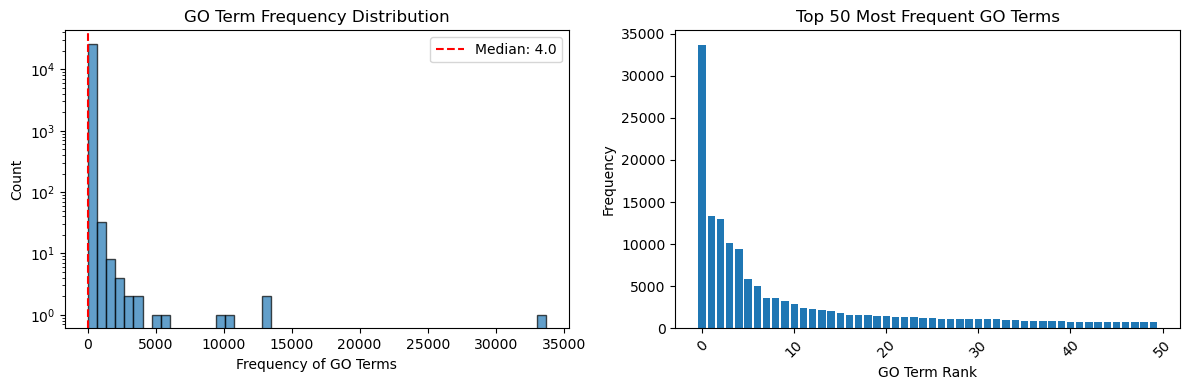


Selected 1585 GO terms with ≥50 occurrences
Filtered training data: 346396 examples


In [10]:
# === ANALYZE GO TERM DISTRIBUTION ===
term_counts = train_df['term'].value_counts()
print("=== GO TERM ANALYSIS ===")
print(f"Total unique GO terms: {len(term_counts)}")
print(f"GO term frequency distribution:\n{term_counts.describe()}")

# Plot GO term frequency distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(term_counts.values, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(term_counts.median(), color='red', linestyle='--', label=f'Median: {term_counts.median()}')
plt.xlabel('Frequency of GO Terms')
plt.ylabel('Count')
plt.title('GO Term Frequency Distribution')
plt.legend()
plt.yscale('log')

plt.subplot(1, 2, 2)
# Top 50 most frequent terms
top_50_terms = term_counts.head(50)
plt.bar(range(len(top_50_terms)), top_50_terms.values)
plt.xlabel('GO Term Rank')
plt.ylabel('Frequency')
plt.title('Top 50 Most Frequent GO Terms')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# === SELECT MEANINGFUL GO TERMS ===
min_occurrence = 50
frequent_terms = term_counts[term_counts >= min_occurrence].index
print(f"\nSelected {len(frequent_terms)} GO terms with ≥{min_occurrence} occurrences")

# Filter training data to frequent terms only
filtered_train_df = train_df[train_df['term'].isin(frequent_terms)]
print(f"Filtered training data: {filtered_train_df.shape[0]} examples")

In [11]:
# === PROTEIN DATASET CLASS ===
class ProteinDataset(Dataset):
    def __init__(self, df, max_length=1024):
        """
        df: DataFrame with 'entry_id' and 'sequence' columns
        max_length: Truncate sequences longer than this
        """
        self.df = df.reset_index(drop=True)
        self.max_length = max_length
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        entry_id = row['entry_id']
        sequence = row['sequence'][:self.max_length]  # Truncate if too long
        return entry_id, sequence

# === ESM EMBEDDING EXTRACTOR ===
def get_esm_embeddings(dataset, batch_size=8, show_progress=True):
    """
    Extract ESM embeddings for all sequences in dataset
    Returns: dict {entry_id: embedding_vector}
    """
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    embeddings = {}
    
    if show_progress:
        from tqdm import tqdm
        iterator = tqdm(dataloader, desc="Extracting embeddings")
    else:
        iterator = dataloader
    
    with torch.no_grad():
        for batch in iterator:
            entry_ids, sequences = batch
            
            # Prepare batch for ESM
            batch_data = [(entry_id, sequence) for entry_id, sequence in zip(entry_ids, sequences)]
            batch_labels, batch_strs, batch_tokens = batch_converter(batch_data)
            batch_tokens = batch_tokens.to(device)
            
            # Get embeddings 
            results = model(batch_tokens, repr_layers=[12], return_contacts=False)
            token_representations = results["representations"][12]
            
            # Create protein embedding (mean of all tokens except CLS and PAD)
            for i, entry_id in enumerate(entry_ids):
                seq_len = len(batch_strs[i])
                embedding = token_representations[i, 1:seq_len+1].mean(dim=0)  # Exclude CLS token
                embeddings[entry_id] = embedding.cpu().numpy()
            
            # Clear GPU memory
            torch.cuda.empty_cache()
    
    return embeddings

# === CREATE LABEL MATRIX ===
def create_label_matrix(train_df, protein_list, term_list):
    """
    Create binary label matrix for multi-label classification
    Returns: sparse matrix (proteins x terms), protein_to_idx mapping
    """
    protein_to_idx = {pid: idx for idx, pid in enumerate(protein_list)}
    term_to_idx = {term: idx for idx, term in enumerate(term_list)}
    
    # Create sparse matrix
    rows, cols = [], []
    for _, row in train_df.iterrows():
        if row['entry_id'] in protein_to_idx and row['term'] in term_to_idx:
            rows.append(protein_to_idx[row['entry_id']])
            cols.append(term_to_idx[row['term']])
    
    data = np.ones(len(rows))
    label_matrix = sp.csr_matrix((data, (rows, cols)), 
                                shape=(len(protein_list), len(term_list)))
    
    return label_matrix, protein_to_idx

In [12]:
# === PHASE 1: SMALL-SCALE VALIDATION ===
def phase_1_validation(train_df, test_df, top_n_terms=100, num_proteins=1000):
    """
    Phase 1: Quick validation with small data
    """
    print("=== PHASE 1: PIPELINE VALIDATION ===")
    
    # 1. Select top N GO terms
    top_terms = train_df['term'].value_counts().head(top_n_terms).index
    phase1_train = train_df[train_df['term'].isin(top_terms)]
    
    # 2. Select proteins that exist in both train and test
    common_proteins = set(phase1_train['entry_id']).intersection(set(test_df['entry_id']))
    phase1_proteins = list(common_proteins)[:num_proteins]
    
    # 3. Filter data
    phase1_train = phase1_train[phase1_train['entry_id'].isin(phase1_proteins)]
    phase1_test = test_df[test_df['entry_id'].isin(phase1_proteins)]
    
    print(f"Phase 1 Data:")
    print(f"- Training examples: {len(phase1_train)}")
    print(f"- Unique proteins: {len(phase1_proteins)}")
    print(f"- GO terms: {len(top_terms)}")
    print(f"- Test sequences: {len(phase1_test)}")
    
    return phase1_train, phase1_test, phase1_proteins, top_terms

# Run Phase 1 setup
phase1_train, phase1_test, phase1_proteins, phase1_terms = phase_1_validation(
    filtered_train_df, test_df, top_n_terms=100, num_proteins=500
)

=== PHASE 1: PIPELINE VALIDATION ===
Phase 1 Data:
- Training examples: 1330
- Unique proteins: 500
- GO terms: 100
- Test sequences: 500


In [13]:
# === EXTRACT EMBEDDINGS FOR PHASE 1 ===
print("Creating datasets...")
train_dataset_phase1 = ProteinDataset(
    test_df[test_df['entry_id'].isin(phase1_proteins)]  # Get sequences from test_df
)

print("Extracting ESM embeddings for training proteins...")
train_embeddings_phase1 = get_esm_embeddings(train_dataset_phase1, batch_size=16)

# Verify embeddings
print(f"Extracted embeddings for {len(train_embeddings_phase1)} proteins")
print(f"Embedding dimension: {list(train_embeddings_phase1.values())[0].shape}")

# === CREATE TRAINING DATA ===
print("Creating label matrix...")
y_train_phase1, protein_map_phase1 = create_label_matrix(
    phase1_train, phase1_proteins, phase1_terms
)

# Create feature matrix
X_train_phase1 = np.array([train_embeddings_phase1[pid] for pid in phase1_proteins])

print(f"Training data shape: X={X_train_phase1.shape}, y={y_train_phase1.shape}")
print(f"Label sparsity: {y_train_phase1.nnz / (y_train_phase1.shape[0] * y_train_phase1.shape[1]) * 100:.2f}%")

Creating datasets...
Extracting ESM embeddings for training proteins...


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 32/32 [11:26<00:00, 21.46s/it]

Extracted embeddings for 500 proteins
Embedding dimension: (480,)
Creating label matrix...
Training data shape: X=(500, 480), y=(500, 100)
Label sparsity: 2.66%


In [14]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np

def train_evaluate_model_safe(X, y, terms, test_size=0.2):
    """
    Train and evaluate a multi-label classifier safely.
    Automatically ignores GO terms with no positive samples in the training split.
    """
    print("=== TRAINING MODEL (SAFE) ===")
    
    # Split data
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=test_size, random_state=42
    )
    
    # Identify columns (GO terms) with at least 1 positive sample in training
    valid_cols = np.where(y_train.sum(axis=0) > 0)[0]
    if len(valid_cols) < y_train.shape[1]:
        removed_terms = [terms[i] for i in range(len(terms)) if i not in valid_cols]
        print(f"Removing {len(removed_terms)} GO terms with no positives in training: {removed_terms[:10]}{'...' if len(removed_terms) > 10 else ''}")
    
    # Filter y to valid GO terms (both train and val)
    y_train_filtered = y_train[:, valid_cols]
    y_val_filtered = y_val[:, valid_cols]
    
    # X does not need row filtering, only column filtering for y labels
    X_train_filtered = X_train
    X_val_filtered = X_val
    
    filtered_terms = [terms[i] for i in valid_cols]
    
    # Multi-output logistic regression
    base_clf = LogisticRegression(
        random_state=42,
        max_iter=1000,
        class_weight='balanced',
        n_jobs=-1
    )
    classifier = MultiOutputClassifier(base_clf)
    
    print("Training classifier...")
    classifier.fit(X_train_filtered, y_train_filtered)
    
    # Predictions
    y_pred = classifier.predict(X_val_filtered)
    
    # Compute micro metrics
    f1 = f1_score(y_val_filtered, y_pred, average='micro')
    precision = precision_score(y_val_filtered, y_pred, average='micro')
    recall = recall_score(y_val_filtered, y_pred, average='micro')
    
    print("=== VALIDATION RESULTS ===")
    print(f"Micro F1-score: {f1:.4f}")
    print(f"Micro Precision: {precision:.4f}")
    print(f"Micro Recall: {recall:.4f}")
    print(f"Number of predicted labels: {y_pred.sum()} / {y_val_filtered.sum()} actual")
    
    return classifier, (f1, precision, recall), filtered_terms


In [15]:
phase1_classifier, phase1_metrics, phase1_terms_filtered = train_evaluate_model_safe(
    X_train_phase1, y_train_phase1.toarray(), phase1_terms
)


=== TRAINING MODEL (SAFE) ===
Removing 2 GO terms with no positives in training: ['GO:0005802', 'GO:0046982']
Training classifier...
=== VALIDATION RESULTS ===
Micro F1-score: 0.3059
Micro Precision: 0.2228
Micro Recall: 0.4879
Number of predicted labels: 543.0 / 248.0 actual


In [16]:
# === PHASE 2: SAFE END-TO-END PIPELINE ===
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np
import scipy.sparse as sp
import torch

def phase2_pipeline(train_df, test_df, term_counts, min_occurrence=50, max_proteins=2000, batch_size=16):
    print("\n=== PHASE 2: SAFE PIPELINE ===")
    
    # Select GO terms with enough occurrences
    phase2_terms = term_counts[term_counts >= min_occurrence].index
    phase2_train = train_df[train_df['term'].isin(phase2_terms)]
    
    # Select proteins present in test_df
    common_proteins = set(phase2_train['entry_id']).intersection(set(test_df['entry_id']))
    phase2_proteins = list(common_proteins)[:max_proteins]
    
    phase2_train = phase2_train[phase2_train['entry_id'].isin(phase2_proteins)]
    phase2_test = test_df[test_df['entry_id'].isin(phase2_proteins)]
    
    print(f"Training examples: {len(phase2_train)}")
    print(f"Unique proteins: {len(phase2_proteins)}")
    print(f"GO terms: {len(phase2_terms)}")
    
    # Create dataset and extract embeddings
    print("Creating ProteinDataset and extracting embeddings...")
    phase2_dataset = ProteinDataset(test_df[test_df['entry_id'].isin(phase2_proteins)])
    phase2_embeddings = get_esm_embeddings(phase2_dataset, batch_size=batch_size)
    
    # Build sparse label matrix
    y_train_phase2, protein_map_phase2 = create_label_matrix(phase2_train, phase2_proteins, phase2_terms)
    X_train_phase2 = np.array([phase2_embeddings[pid] for pid in phase2_proteins])
    
    print(f"Feature matrix: X={X_train_phase2.shape}, Label matrix: y={y_train_phase2.shape}")
    
    # Train safe classifier (remove GO terms with no positives in training)
    def train_safe_classifier(X, y, terms, test_size=0.2):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42)
        
        # Identify columns with at least 1 positive sample
        valid_cols = np.where(y_train.sum(axis=0) > 0)[0]
        if len(valid_cols) < y_train.shape[1]:
            removed_terms = [terms[i] for i in range(len(terms)) if i not in valid_cols]
            print(f"Removing {len(removed_terms)} GO terms with no positives in training: {removed_terms[:10]}{'...' if len(removed_terms) > 10 else ''}")
        
        # Filter y to valid columns
        y_train_filtered = y_train[:, valid_cols]
        y_val_filtered = y_val[:, valid_cols]
        filtered_terms = [terms[i] for i in valid_cols]
        
        # Train multi-output logistic regression
        base_clf = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced', n_jobs=-1)
        clf = MultiOutputClassifier(base_clf)
        clf.fit(X_train, y_train_filtered)
        
        # Predictions & metrics
        y_pred = clf.predict(X_val)
        f1 = f1_score(y_val_filtered, y_pred, average='micro')
        precision = precision_score(y_val_filtered, y_pred, average='micro')
        recall = recall_score(y_val_filtered, y_pred, average='micro')
        
        print("=== VALIDATION RESULTS ===")
        print(f"Micro F1-score: {f1:.4f}")
        print(f"Micro Precision: {precision:.4f}")
        print(f"Micro Recall: {recall:.4f}")
        print(f"Predicted labels: {y_pred.sum()} / {y_val_filtered.sum()} actual")
        
        return clf, (f1, precision, recall), filtered_terms
    
    # Train and evaluate
    classifier, metrics, filtered_terms = train_safe_classifier(X_train_phase2, y_train_phase2.toarray(), phase2_terms)
    
    return classifier, metrics, filtered_terms, X_train_phase2, y_train_phase2

# === Run Phase 2 ===
phase2_classifier, phase2_metrics, phase2_terms_filtered, X_train_phase2, y_train_phase2 = phase2_pipeline(
    filtered_train_df, test_df, term_counts,
    min_occurrence=50,
    max_proteins=2000,
    batch_size=16
)



=== PHASE 2: SAFE PIPELINE ===
Training examples: 9369
Unique proteins: 2000
GO terms: 1585
Creating ProteinDataset and extracting embeddings...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [45:59<00:00, 22.07s/it]


Feature matrix: X=(2000, 480), Label matrix: y=(2000, 1585)
Removing 229 GO terms with no positives in training: ['GO:0038023', 'GO:0048477', 'GO:0031594', 'GO:0031252', 'GO:0003730', 'GO:0004722', 'GO:0002119', 'GO:0071260', 'GO:0043022', 'GO:0019903']...
=== VALIDATION RESULTS ===
Micro F1-score: 0.1315
Micro Precision: 0.0805
Micro Recall: 0.3595
Predicted labels: 7628.0 / 1708.0 actual


In [17]:
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm

def predict_novel_proteins_fullscale(classifier, novel_df, term_list, batch_size=1000, esm_batch_size=8, output_file="novel_predictions.csv"):
    """
    Predict GO terms for a large set of novel proteins.
    Saves predictions incrementally to CSV to avoid memory issues.
    
    Parameters:
        classifier : trained multi-output classifier
        novel_df   : DataFrame with 'entry_id' and 'sequence'
        term_list  : list of terms used during training
        batch_size : number of proteins per batch
        esm_batch_size : batch size for ESM embeddings
        output_file: path to save predictions CSV
    """
    print("\n=== PREDICTING NOVEL PROTEINS FULL-SCALE ===")
    
    # Initialize CSV with headers
    columns = ['entry_id', 'GO_term', 'probability']
    pd.DataFrame(columns=columns).to_csv(output_file, index=False)
    
    # Process in batches
    num_batches = (len(novel_df) - 1) // batch_size + 1
    for i in range(num_batches):
        batch_df = novel_df.iloc[i*batch_size : (i+1)*batch_size]
        batch_dataset = ProteinDataset(batch_df)
        
        print(f"Processing batch {i+1}/{num_batches} ({len(batch_df)} proteins)...")
        
        # Extract embeddings
        batch_embeddings = get_esm_embeddings(batch_dataset, batch_size=esm_batch_size, show_progress=True)
        batch_proteins = list(batch_embeddings.keys())
        X_batch = np.array([batch_embeddings[pid] for pid in batch_proteins])
        
        # Predictions
        y_pred_batch = classifier.predict(X_batch)
        y_pred_proba = classifier.predict_proba(X_batch)
        
        # Prepare rows to save
        rows = []
        for j, pid in enumerate(batch_proteins):
            for k, term in enumerate(term_list):
                if y_pred_batch[j, k] == 1:
                    prob = y_pred_proba[k][j][1]
                    rows.append({'entry_id': pid, 'GO_term': term, 'probability': prob})
        
        # Append to CSV
        pd.DataFrame(rows).to_csv(output_file, mode='a', header=False, index=False)
        
    print(f"Predictions saved to {output_file}")
    return output_file


In [18]:
# Predict on all novel proteins (~140k)
predict_novel_proteins_fullscale(
    classifier=phase2_classifier,
    novel_df=novel_test_df,
    term_list=phase2_terms_filtered,
    batch_size=1000,      # process 1k proteins per loop
    esm_batch_size=8,     # ESM embeddings batch size for GPU
    output_file="novel_protein_predictions1.csv"
)



=== PREDICTING NOVEL PROTEINS FULL-SCALE ===
Processing batch 1/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [21:25<00:00, 10.28s/it]


Processing batch 2/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [20:48<00:00,  9.99s/it]


Processing batch 3/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [20:06<00:00,  9.65s/it]


Processing batch 4/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [19:22<00:00,  9.30s/it]


Processing batch 5/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [20:08<00:00,  9.67s/it]


Processing batch 6/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [20:19<00:00,  9.76s/it]


Processing batch 7/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [19:45<00:00,  9.49s/it]


Processing batch 8/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [19:40<00:00,  9.44s/it]


Processing batch 9/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [20:41<00:00,  9.93s/it]


Processing batch 10/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [20:41<00:00,  9.94s/it]


Processing batch 11/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [20:45<00:00,  9.97s/it]


Processing batch 12/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [19:32<00:00,  9.38s/it]


Processing batch 13/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [19:58<00:00,  9.58s/it]


Processing batch 14/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [19:12<00:00,  9.22s/it]


Processing batch 15/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [14:17<00:00,  6.86s/it]


Processing batch 16/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [19:12<00:00,  9.22s/it]


Processing batch 17/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [17:12<00:00,  8.26s/it]


Processing batch 18/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [16:18<00:00,  7.83s/it]


Processing batch 19/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [21:22<00:00, 10.26s/it]


Processing batch 20/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [16:46<00:00,  8.05s/it]


Processing batch 21/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [17:08<00:00,  8.23s/it]


Processing batch 22/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [18:50<00:00,  9.04s/it]


Processing batch 23/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [14:50<00:00,  7.12s/it]


Processing batch 24/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [17:37<00:00,  8.46s/it]


Processing batch 25/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [20:14<00:00,  9.71s/it]


Processing batch 26/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [13:04<00:00,  6.28s/it]


Processing batch 27/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [19:30<00:00,  9.36s/it]


Processing batch 28/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [16:35<00:00,  7.96s/it]


Processing batch 29/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [16:51<00:00,  8.10s/it]


Processing batch 30/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [18:00<00:00,  8.64s/it]


Processing batch 31/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [18:52<00:00,  9.06s/it]


Processing batch 32/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [17:20<00:00,  8.32s/it]


Processing batch 33/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [19:18<00:00,  9.27s/it]


Processing batch 34/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [15:52<00:00,  7.62s/it]


Processing batch 35/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [18:53<00:00,  9.07s/it]


Processing batch 36/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [17:39<00:00,  8.48s/it]


Processing batch 37/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [18:35<00:00,  8.92s/it]


Processing batch 38/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [15:55<00:00,  7.64s/it]


Processing batch 39/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [17:25<00:00,  8.36s/it]


Processing batch 40/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [17:25<00:00,  8.36s/it]


Processing batch 41/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [19:31<00:00,  9.38s/it]


Processing batch 42/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [17:16<00:00,  8.29s/it]


Processing batch 43/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [14:25<00:00,  6.93s/it]


Processing batch 44/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [12:51<00:00,  6.18s/it]


Processing batch 45/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [10:59<00:00,  5.28s/it]


Processing batch 46/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [16:37<00:00,  7.98s/it]


Processing batch 47/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [17:40<00:00,  8.49s/it]


Processing batch 48/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [15:05<00:00,  7.25s/it]


Processing batch 49/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [14:44<00:00,  7.07s/it]


Processing batch 50/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [19:18<00:00,  9.27s/it]


Processing batch 51/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [16:15<00:00,  7.81s/it]


Processing batch 52/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [10:46<00:00,  5.17s/it]


Processing batch 53/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [13:38<00:00,  6.55s/it]


Processing batch 54/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [13:07<00:00,  6.30s/it]


Processing batch 55/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [17:48<00:00,  8.55s/it]


Processing batch 56/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [17:43<00:00,  8.51s/it]


Processing batch 57/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [14:19<00:00,  6.88s/it]


Processing batch 58/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [17:37<00:00,  8.46s/it]


Processing batch 59/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [18:25<00:00,  8.84s/it]


Processing batch 60/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [14:54<00:00,  7.16s/it]


Processing batch 61/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [11:33<00:00,  5.55s/it]


Processing batch 62/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [10:50<00:00,  5.20s/it]


Processing batch 63/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [16:46<00:00,  8.05s/it]


Processing batch 64/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [17:22<00:00,  8.34s/it]


Processing batch 65/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [17:47<00:00,  8.54s/it]


Processing batch 66/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [14:24<00:00,  6.91s/it]


Processing batch 67/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [19:09<00:00,  9.19s/it]


Processing batch 68/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [17:53<00:00,  8.59s/it]


Processing batch 69/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [14:20<00:00,  6.88s/it]


Processing batch 70/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [12:07<00:00,  5.82s/it]


Processing batch 71/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [10:57<00:00,  5.26s/it]


Processing batch 72/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [17:24<00:00,  8.36s/it]


Processing batch 73/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [17:52<00:00,  8.58s/it]


Processing batch 74/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [16:28<00:00,  7.91s/it]


Processing batch 75/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [15:23<00:00,  7.39s/it]


Processing batch 76/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [19:26<00:00,  9.33s/it]


Processing batch 77/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [17:38<00:00,  8.47s/it]


Processing batch 78/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [11:50<00:00,  5.68s/it]


Processing batch 79/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [13:38<00:00,  6.54s/it]


Processing batch 80/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [12:45<00:00,  6.12s/it]


Processing batch 81/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [17:38<00:00,  8.47s/it]


Processing batch 82/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [17:53<00:00,  8.59s/it]


Processing batch 83/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [16:30<00:00,  7.92s/it]


Processing batch 84/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [14:53<00:00,  7.15s/it]


Processing batch 85/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [16:22<00:00,  7.86s/it]


Processing batch 86/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [13:59<00:00,  6.72s/it]


Processing batch 87/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [16:18<00:00,  7.82s/it]


Processing batch 88/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [12:46<00:00,  6.13s/it]


Processing batch 89/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [17:05<00:00,  8.20s/it]


Processing batch 90/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [13:34<00:00,  6.51s/it]


Processing batch 91/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [16:39<00:00,  7.99s/it]


Processing batch 92/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [14:25<00:00,  6.92s/it]


Processing batch 93/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [15:35<00:00,  7.48s/it]


Processing batch 94/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [14:41<00:00,  7.06s/it]


Processing batch 95/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [14:19<00:00,  6.88s/it]


Processing batch 96/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [13:41<00:00,  6.57s/it]


Processing batch 97/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [13:21<00:00,  6.41s/it]


Processing batch 98/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [12:16<00:00,  5.89s/it]


Processing batch 99/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [09:56<00:00,  4.77s/it]


Processing batch 100/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [07:39<00:00,  3.67s/it]


Processing batch 101/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [13:17<00:00,  6.38s/it]


Processing batch 102/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [15:22<00:00,  7.38s/it]


Processing batch 103/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [12:28<00:00,  5.99s/it]


Processing batch 104/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [13:10<00:00,  6.32s/it]


Processing batch 105/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [12:11<00:00,  5.85s/it]


Processing batch 106/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [08:51<00:00,  4.26s/it]


Processing batch 107/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [07:22<00:00,  3.54s/it]


Processing batch 108/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [12:00<00:00,  5.76s/it]


Processing batch 109/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [14:38<00:00,  7.03s/it]


Processing batch 110/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [12:44<00:00,  6.11s/it]


Processing batch 111/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [11:25<00:00,  5.48s/it]


Processing batch 112/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [12:55<00:00,  6.21s/it]


Processing batch 113/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [10:43<00:00,  5.14s/it]


Processing batch 114/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [08:06<00:00,  3.90s/it]


Processing batch 115/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [09:48<00:00,  4.71s/it]


Processing batch 116/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [12:53<00:00,  6.19s/it]


Processing batch 117/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [13:23<00:00,  6.43s/it]


Processing batch 118/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [11:45<00:00,  5.65s/it]


Processing batch 119/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [12:37<00:00,  6.06s/it]


Processing batch 120/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [11:06<00:00,  5.33s/it]


Processing batch 121/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [08:44<00:00,  4.20s/it]


Processing batch 122/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [08:28<00:00,  4.07s/it]


Processing batch 123/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [11:31<00:00,  5.53s/it]


Processing batch 124/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [12:56<00:00,  6.21s/it]


Processing batch 125/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [10:02<00:00,  4.82s/it]


Processing batch 126/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [13:39<00:00,  6.55s/it]


Processing batch 127/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [10:48<00:00,  5.19s/it]


Processing batch 128/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [08:53<00:00,  4.27s/it]


Processing batch 129/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [06:59<00:00,  3.36s/it]


Processing batch 130/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [12:41<00:00,  6.09s/it]


Processing batch 131/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [13:47<00:00,  6.62s/it]


Processing batch 132/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [10:50<00:00,  5.21s/it]


Processing batch 133/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [07:40<00:00,  3.69s/it]


Processing batch 134/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [08:09<00:00,  3.92s/it]


Processing batch 135/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [08:06<00:00,  3.89s/it]


Processing batch 136/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [08:49<00:00,  4.24s/it]


Processing batch 137/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [08:22<00:00,  4.02s/it]


Processing batch 138/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [10:03<00:00,  4.83s/it]


Processing batch 139/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [08:14<00:00,  3.96s/it]


Processing batch 140/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [07:48<00:00,  3.75s/it]


Processing batch 141/142 (1000 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 125/125 [08:22<00:00,  4.02s/it]


Processing batch 142/142 (905 proteins)...


Extracting embeddings: 100%|█████████████████████████████████████████████████████████| 114/114 [07:29<00:00,  3.95s/it]


Predictions saved to novel_protein_predictions1.csv


'novel_protein_predictions1.csv'

In [19]:
import pandas as pd
import numpy as np

def prepare_cafa_submission(pred_csv, go_obo_file, output_file="submission.tsv", max_terms=1500):
    """
    - Loads raw prediction CSV (entry_id, GO_term, probability)
    - Propagates predictions up the GO hierarchy
    - Limits to max_terms per protein
    - Formats final CAFA submission file
    """
    print("\n=== Preparing CAFA Submission File ===")

    print("Loading predictions...")
    df = pd.read_csv(pred_csv)

    print("Loading GO ontology...")
    parents = {}

    # Parse go-basic.obo to build term → parents dictionary
    with open(go_obo_file, 'r') as f:
        current_term = None
        for line in f:
            line = line.strip()
            if line.startswith("id: GO:"):
                current_term = line.split("id: ")[1]
                parents[current_term] = []
            if line.startswith("is_a: GO:") and current_term:
                parent_term = line.split("is_a: ")[1].split()[0]
                parents[current_term].append(parent_term)

    print("Propagating predictions to parent terms...")
    propagated_rows = []

    for protein, group in df.groupby("entry_id"):
        term_scores = dict(zip(group.GO_term, group.probability))

        # BFS upward propagation
        queue = list(term_scores.keys())
        visited = set()

        while queue:
            term = queue.pop()
            if term in visited: 
                continue
            visited.add(term)

            if term in parents:
                for p in parents[term]:
                    new_score = term_scores.get(term, 0)
                    term_scores[p] = max(term_scores.get(p, 0), new_score)
                    queue.append(p)

        # Keep highest prob terms and limit to max_terms
        top_terms = sorted(term_scores.items(), key=lambda x: x[1], reverse=True)[:max_terms]

        for term, score in top_terms:
            if score > 0:  # CAFA requirement: no zeroes
                propagated_rows.append([protein, term, round(score, 3)])

    print("Saving formatted submission file...")
    sub = pd.DataFrame(propagated_rows, columns=["ProteinID", "GO_ID", "Score"])
    sub.to_csv(output_file, sep="\t", index=False, header=False)

    print(f"\nSubmission ready: {output_file}")
    print(f"Total predictions: {len(sub)}")
    return sub


In [20]:
prepare_cafa_submission(
    pred_csv="novel_protein_predictions1.csv",
    go_obo_file="data/Train/go-basic.obo",
    output_file="cafa6_submission.tsv"
)



=== Preparing CAFA Submission File ===
Loading predictions...
Loading GO ontology...
Propagating predictions to parent terms...
Saving formatted submission file...

Submission ready: cafa6_submission.tsv
Total predictions: 10787694


,ProteinID,GO_ID,Score
0,A0A017SE81,GO:0005739,0.736
1,A0A017SE81,GO:0043231,0.736
2,A0A017SE81,GO:0043227,0.736
3,A0A017SE81,GO:0043229,0.736
4,A0A017SE81,GO:0043226,0.736
...,...,...,...
10787689,X6R8R1,GO:0043229,0.557
10787690,X6R8R1,GO:0043226,0.557
10787691,X6R8R1,GO:0035091,0.530
10787692,X6R8R1,GO:0042803,0.507
